# Simple MNIST convnet

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2015/06/19<br>
**Last modified:** 2020/04/21<br>
**Description:** A simple convnet that achieves ~99% test accuracy on MNIST.

## Setup

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the data

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Build the model

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

## Train the model

In [ ]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 36s 84ms/step - loss: 0.7541 - accuracy: 0.7699 - val_loss: 0.0833 - val_accuracy: 0.9788
Epoch 2/15
422/422 [==============================] - 35s 83ms/step - loss: 0.1191 - accuracy: 0.9640 - val_loss: 0.0573 - val_accuracy: 0.9853
Epoch 3/15
422/422 [==============================] - 36s 85ms/step - loss: 0.0867 - accuracy: 0.9719 - val_loss: 0.0480 - val_accuracy: 0.9858
Epoch 4/15
422/422 [==============================] - 35s 83ms/step - loss: 0.0685 - accuracy: 0.9795 - val_loss: 0.0425 - val_accuracy: 0.9897
Epoch 5/15
422/422 [==============================] - 35s 83ms/step - loss: 0.0658 - accuracy: 0.9799 - val_loss: 0.0379 - val_accuracy: 0.9900
Epoch 6/15
422/422 [==============================] - 35s 83ms/step - loss: 0.0532 - accuracy: 0.9834 - val_loss: 0.0356 - val_accuracy: 0.9915
Epoch 7/15
422/422 [==============================] - 35s 83ms/step - loss: 0.0519 - accuracy: 0.9837 - val_loss: 0.0350 - val_accuracy:

## Evaluate the trained model

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.025509878993034363
Test accuracy: 0.9908999800682068


## Get layer activations





In [ ]:
from keras.models import Model
layer_outputs = []
for i in range(0, len(model.layers)):
    tmp_model = Model(model.layers[0].input, model.layers[i].output)
    tmp_output = tmp_model.predict(x_test)
    layer_outputs.append(tmp_output)

In [ ]:
print(len(layer_outputs))

7


In [ ]:
print(layer_outputs[0].shape)

(10000, 26, 26, 32)


In [ ]:
!pip install EnsemblePursuit

In [ ]:
neurons=layer_outputs[1].reshape(10000,-1)

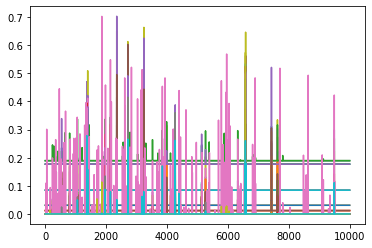

In [ ]:
import matplotlib.pyplot as plt
for j in range(100): 
  plt.plot(neurons[:,j])


In [ ]:
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit

In [ ]:
def compute_rfield(x_test,V):
    #Reshape x_test
    imgs=x_test.reshape(10000,-1).T
    lam=10
    npix=28*28
    B0 = np.linalg.solve((imgs @ imgs.T + lam * np.eye(npix)),  (imgs @ V)).reshape(28,28,15)
    return B0

def receptive_fields_of_ind_layers(layer_ind,layer_outputs,x_test):
  neurons=layer_outputs[layer_ind].reshape(10000,-1)
  ep=EnsemblePursuit(n_components=15,n_kmeans=15,lam=0.5)
  ep.fit(neurons)
  V=ep.components_
  U=ep.weights.flatten()
  B0=compute_rfield(x_test,V)
  for j in range(0,15):
    n_neurons=np.nonzero(ep.weights[:,j].flatten())[0].shape[0]
    plt.imshow(B0[:,:,j],cmap='bwr')
    plt.title('Layer ind '+str(layer_ind)+', n_neurons='+str(n_neurons))
    plt.show()

obtained 15 PCs in 4.6671 seconds
initialized 15 clusters with k-means in 10.0766 seconds
ensemble 0, time 0.41, nr neurons 75, EV 0.0252
ensemble 14, time 5.17, nr neurons 37, EV 0.1045
average sparsity is 0.0084


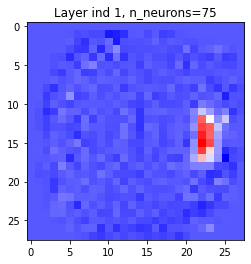

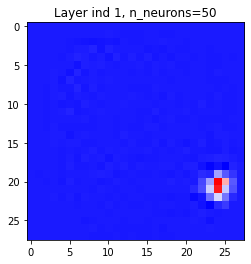

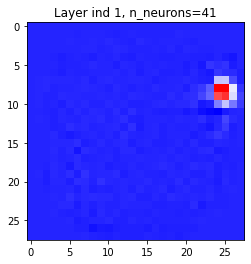

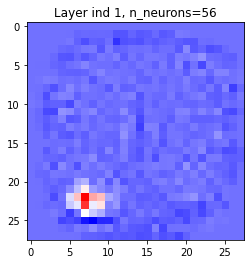

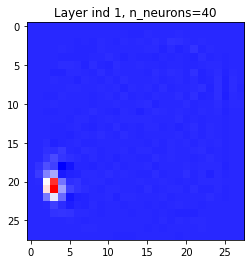

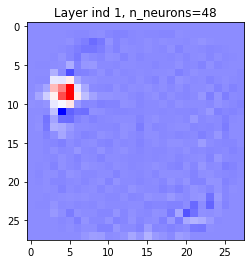

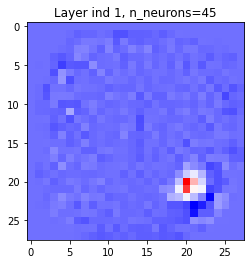

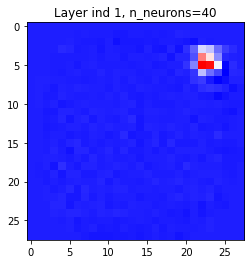

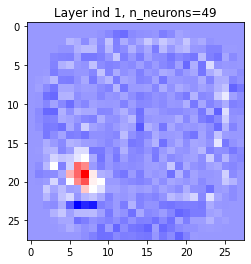

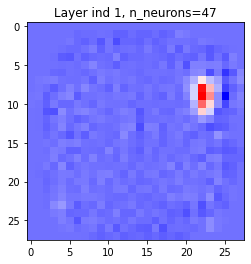

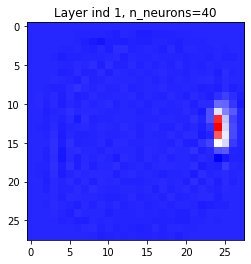

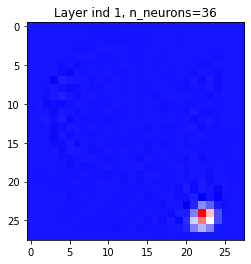

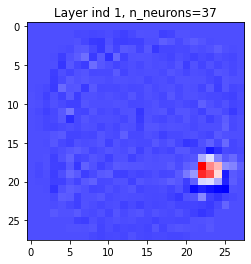

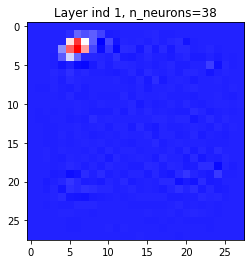

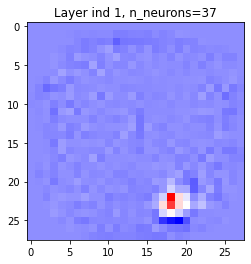

In [ ]:
receptive_fields_of_ind_layers(1,layer_outputs,x_test)

In [ ]:
from sklearn.decomposition import PCA
def PCA_receptive_fields_of_ind_layers(layer_ind,layer_outputs,x_test):
  neurons=layer_outputs[layer_ind].reshape(10000,-1)
  pc=PCA(n_components=15)
  V=pc.fit_transform(neurons)
  B0=compute_rfield(x_test,V)
  for j in range(0,15):
    plt.imshow(B0[:,:,j],cmap='bwr')
    plt.title('Layer ind '+str(layer_ind)+'PC: '+str(j))
    plt.show()

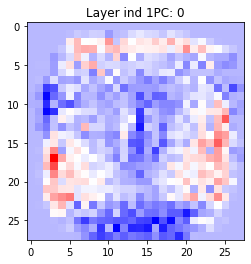

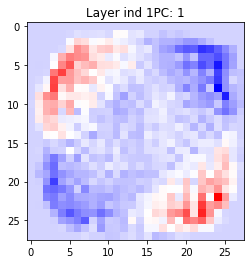

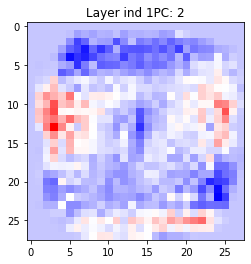

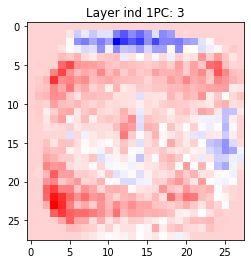

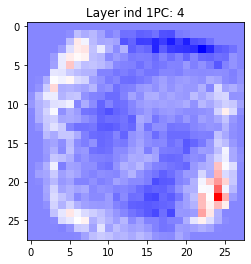

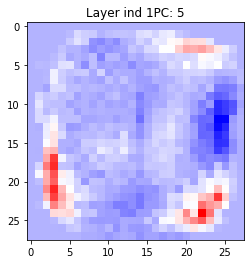

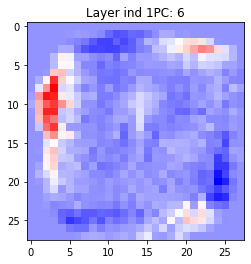

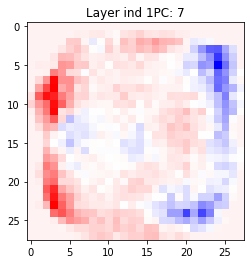

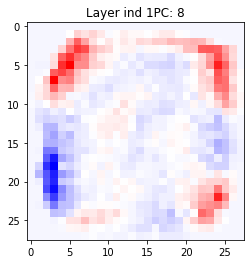

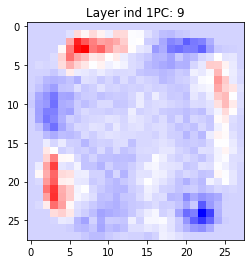

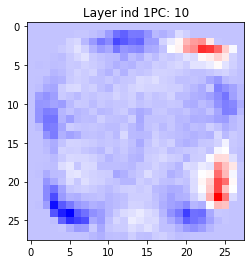

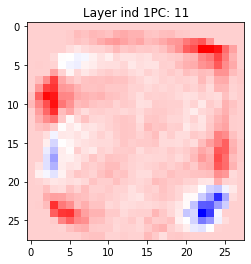

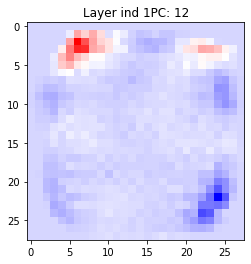

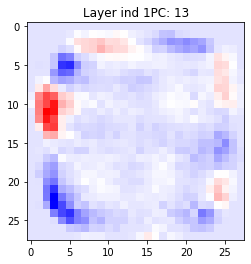

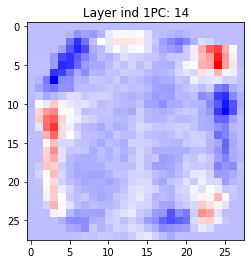

In [ ]:
PCA_receptive_fields_of_ind_layers(1,layer_outputs,x_test)

obtained 15 PCs in 6.0879 seconds
initialized 15 clusters with k-means in 5.9858 seconds
ensemble 0, time 0.30, nr neurons 46, EV 0.0137
ensemble 14, time 4.23, nr neurons 20, EV 0.0473
average sparsity is 0.0037


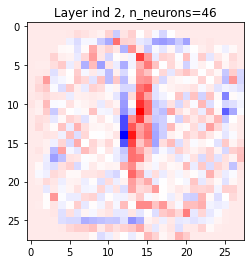

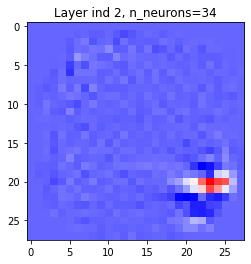

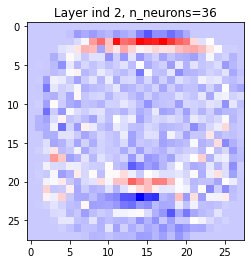

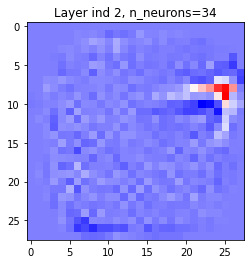

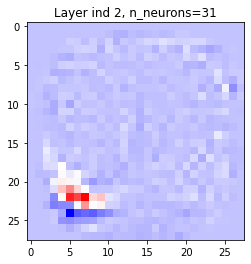

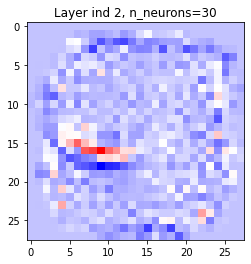

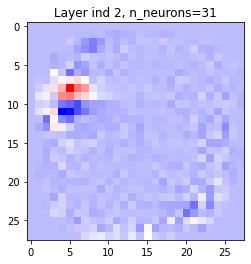

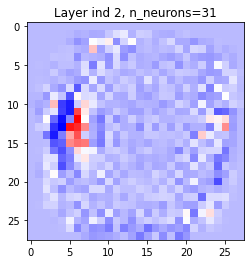

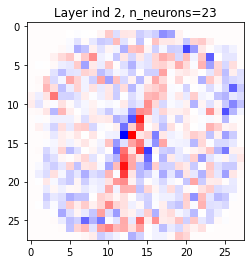

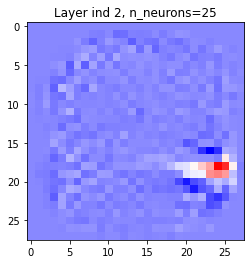

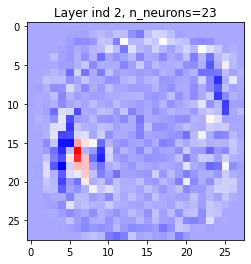

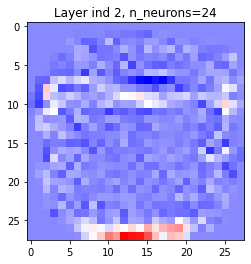

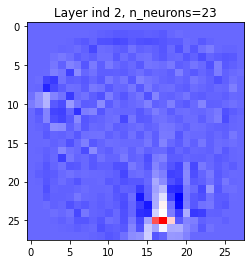

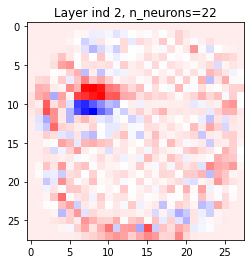

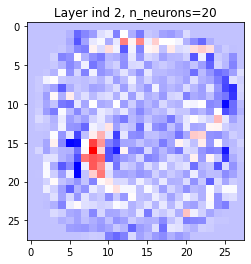

In [ ]:
receptive_fields_of_ind_layers(2,layer_outputs,x_test)

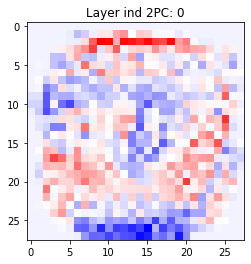

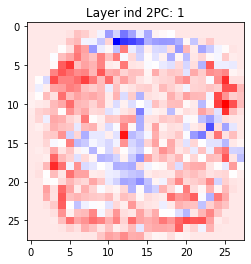

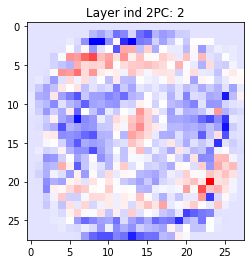

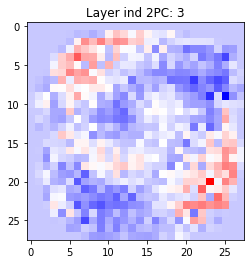

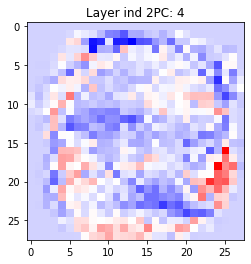

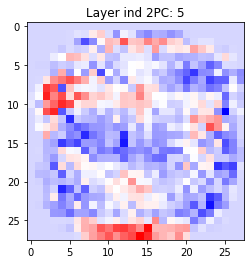

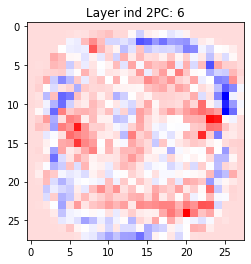

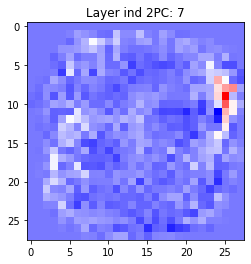

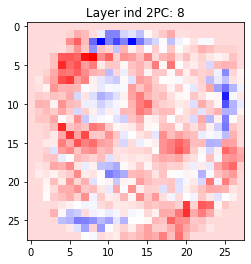

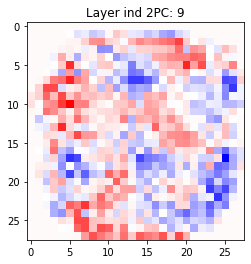

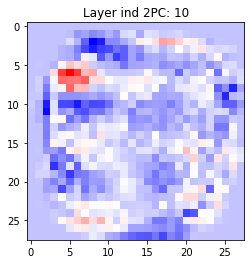

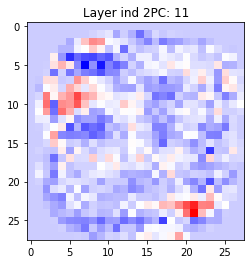

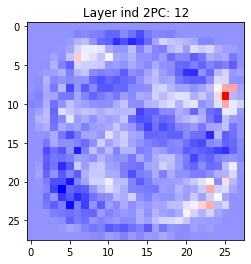

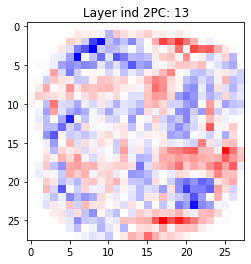

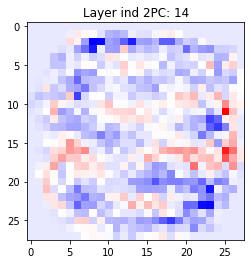

In [ ]:
PCA_receptive_fields_of_ind_layers(2,layer_outputs,x_test)

obtained 15 PCs in 1.6660 seconds
initialized 15 clusters with k-means in 2.3544 seconds
ensemble 0, time 0.10, nr neurons 22, EV 0.0092
ensemble 14, time 1.25, nr neurons 6, EV 0.0768
average sparsity is 0.0075


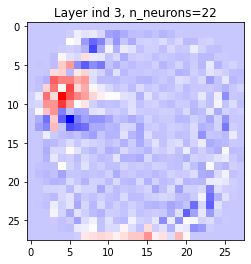

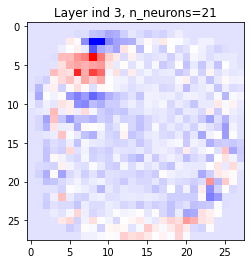

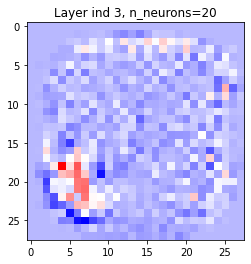

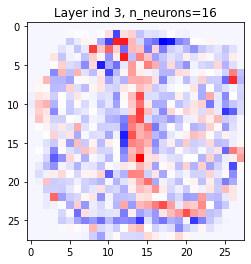

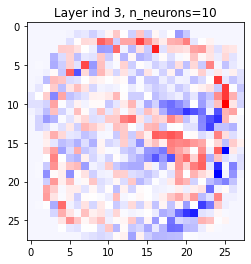

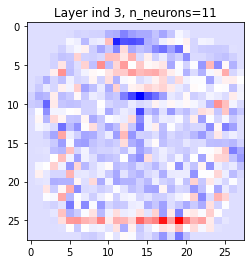

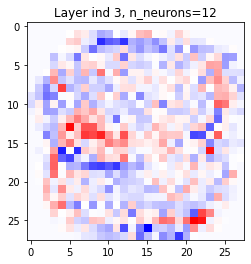

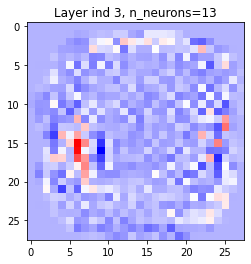

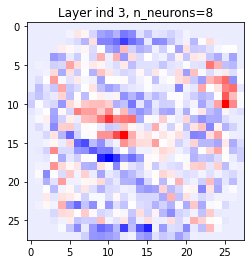

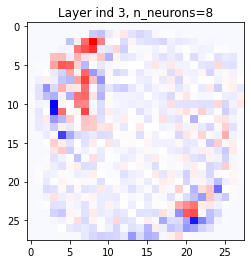

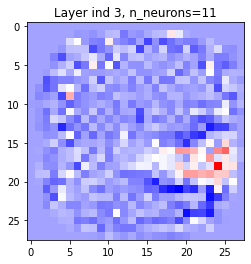

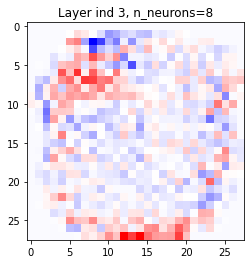

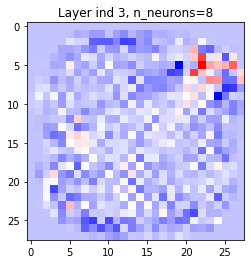

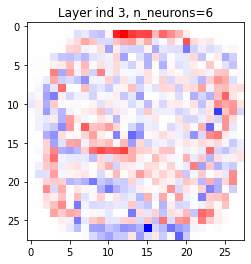

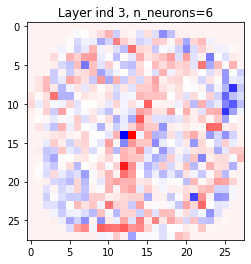

In [ ]:
receptive_fields_of_ind_layers(3,layer_outputs,x_test)

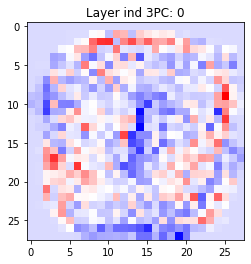

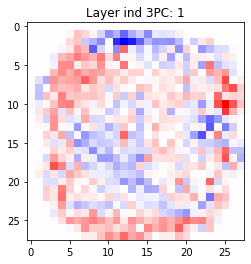

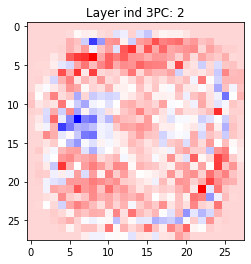

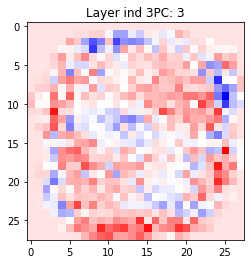

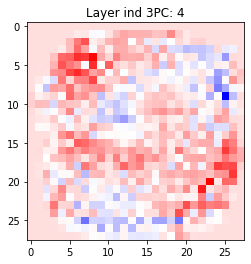

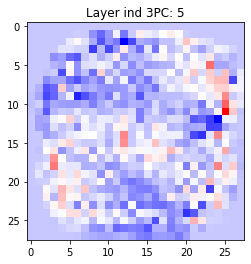

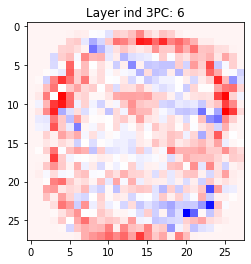

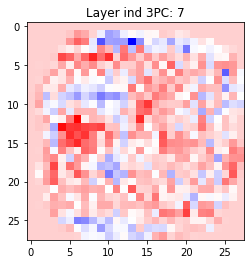

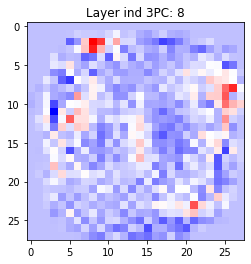

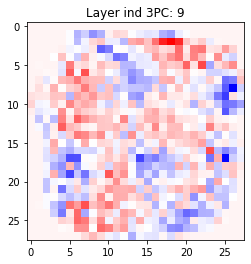

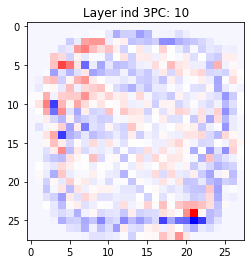

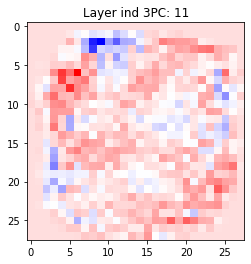

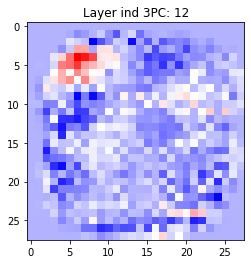

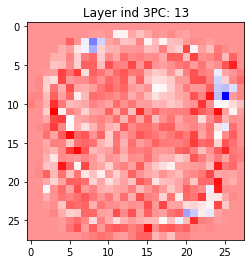

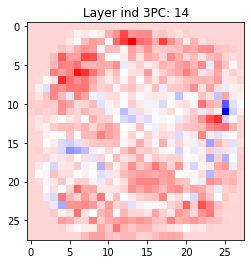

In [ ]:
PCA_receptive_fields_of_ind_layers(3,layer_outputs,x_test)

obtained 15 PCs in 1.6869 seconds
initialized 15 clusters with k-means in 2.3573 seconds
ensemble 0, time 0.10, nr neurons 22, EV 0.0092
ensemble 14, time 1.27, nr neurons 6, EV 0.0768
average sparsity is 0.0075


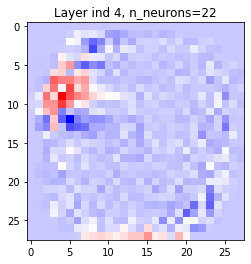

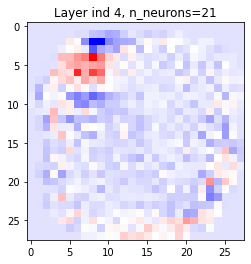

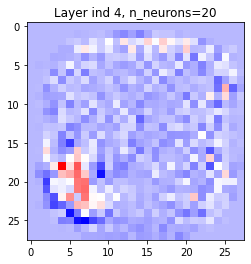

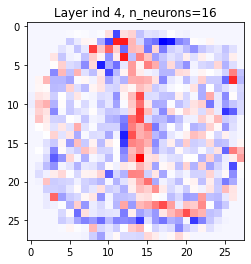

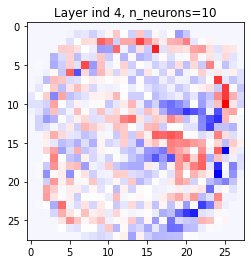

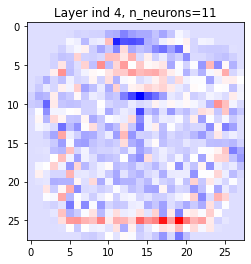

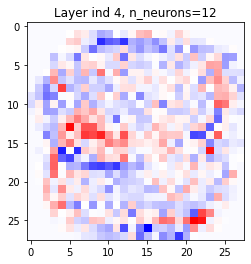

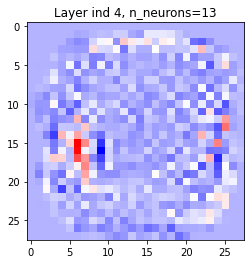

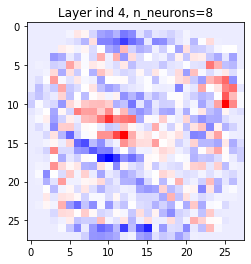

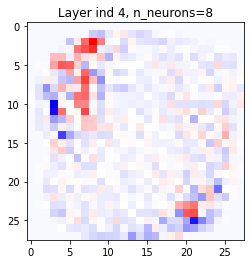

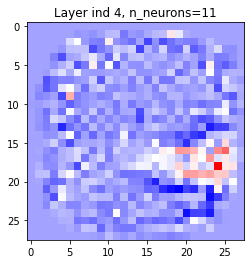

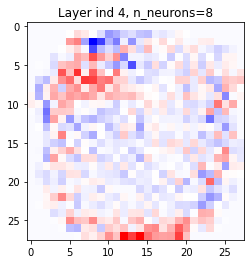

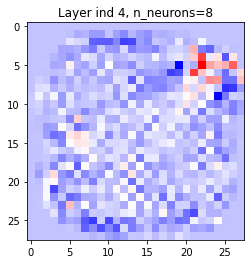

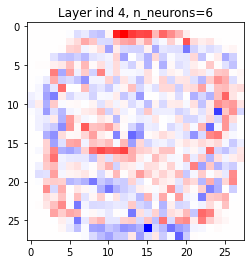

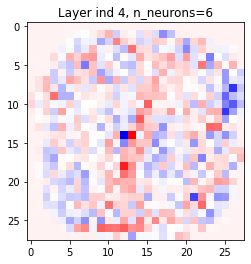

In [ ]:
receptive_fields_of_ind_layers(4,layer_outputs,x_test)

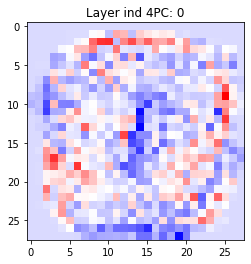

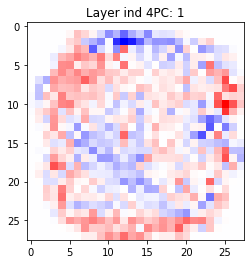

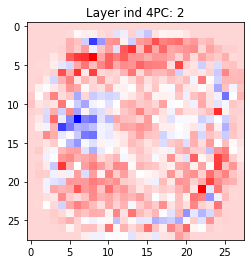

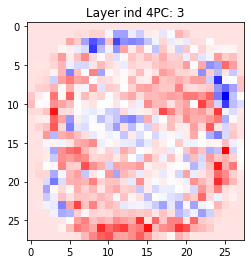

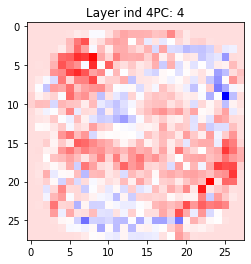

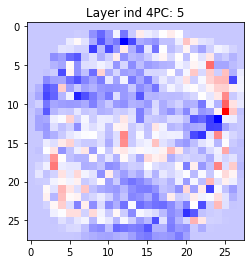

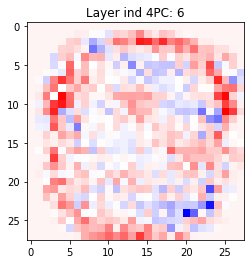

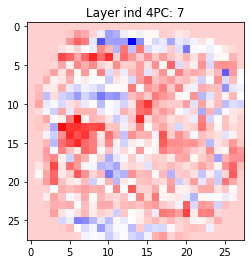

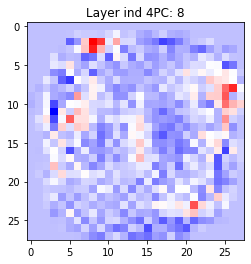

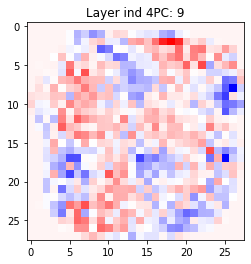

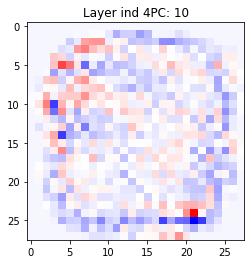

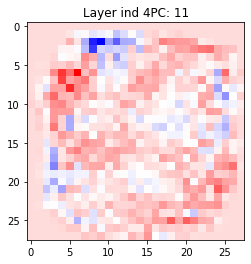

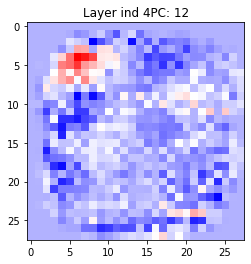

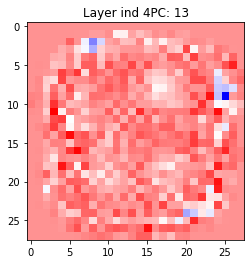

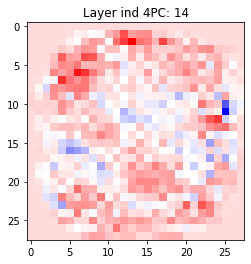

In [ ]:
PCA_receptive_fields_of_ind_layers(4,layer_outputs,x_test)

obtained 15 PCs in 1.6512 seconds
initialized 15 clusters with k-means in 2.3695 seconds
ensemble 0, time 0.10, nr neurons 22, EV 0.0092
ensemble 14, time 1.26, nr neurons 6, EV 0.0768
average sparsity is 0.0075


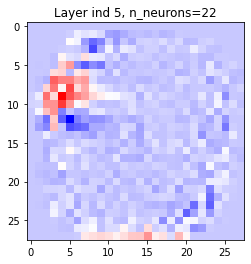

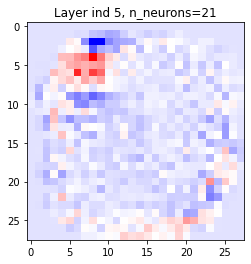

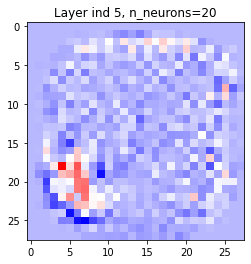

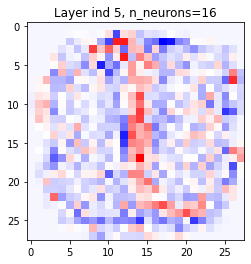

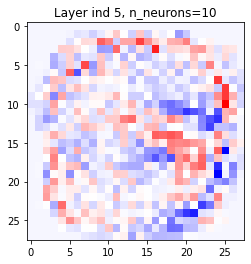

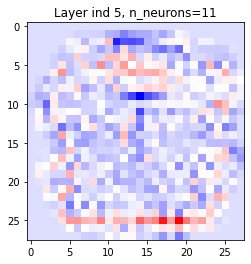

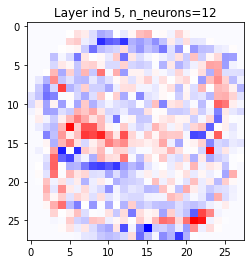

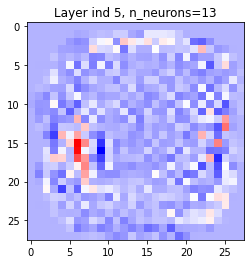

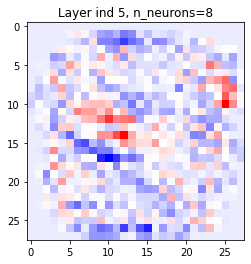

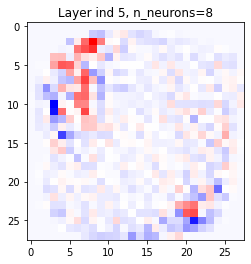

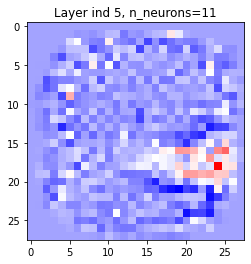

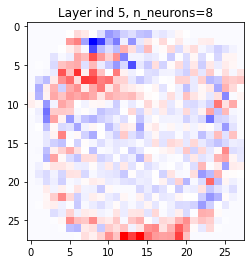

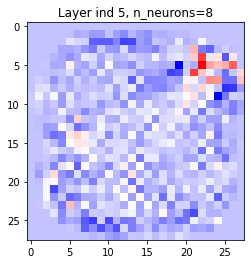

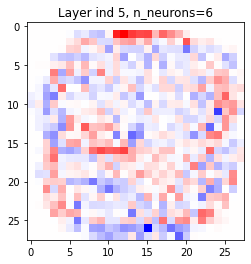

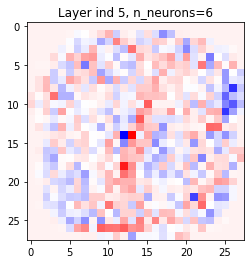

In [ ]:
receptive_fields_of_ind_layers(5,layer_outputs,x_test)

## Across layers

In [ ]:
def concat_layer_activations(layer_outputs):
  act_arr=np.zeros((10000,1))
  for j in range(1,4):
    activations=layer_outputs[j].reshape(10000,-1)
    print(activations.shape)
    act_arr=np.hstack((act_arr,activations))
  act_arr=act_arr[:,1:]
  return act_arr

In [ ]:
act_arr=concat_layer_activations(layer_outputs)

(10000, 5408)
(10000, 7744)
(10000, 1600)


In [ ]:
def compute_rfield(x_test,V):
    #Reshape x_test
    imgs=x_test.reshape(10000,-1).T
    lam=10
    npix=28*28
    B0 = np.linalg.solve((imgs @ imgs.T + lam * np.eye(npix)),  (imgs @ V)).reshape(28,28,15)
    return B0

def receptive_fields_act_arr(act_arr,x_test):
  ep=EnsemblePursuit(n_components=15,n_kmeans=15,lam=0.1)
  ep.fit(act_arr)
  V=ep.components_
  U=ep.weights.flatten()
  B0=compute_rfield(x_test,V)
  for j in range(0,15):
    n_neurons=np.nonzero(ep.weights[:,j].flatten())[0].shape[0]
    plt.imshow(B0[:,:,j],cmap='bwr')
    plt.title('n_neurons='+str(n_neurons))
    plt.show()

obtained 15 PCs in 10.0408 seconds
initialized 15 clusters with k-means in 19.3816 seconds
ensemble 0, time 3.73, nr neurons 1409, EV 0.0319
ensemble 14, time 31.48, nr neurons 279, EV 0.1597
average sparsity is 0.0442


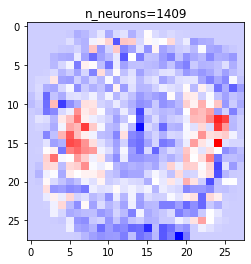

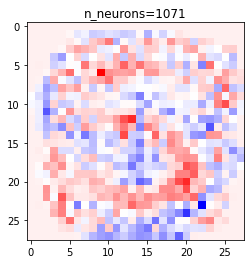

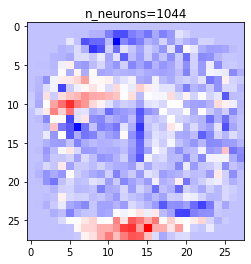

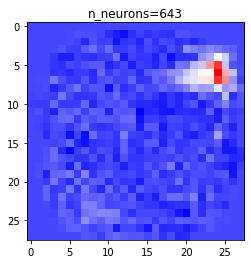

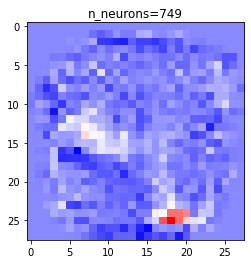

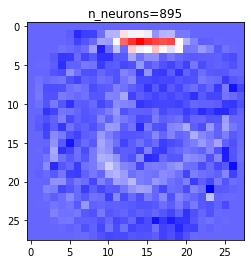

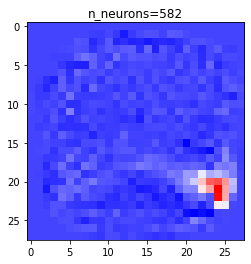

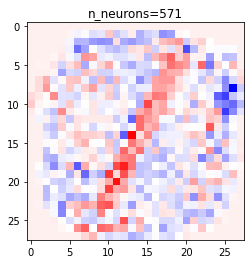

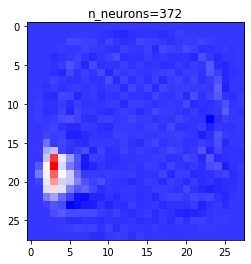

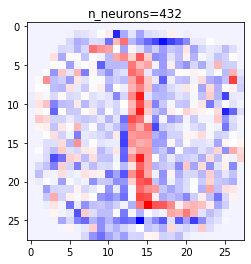

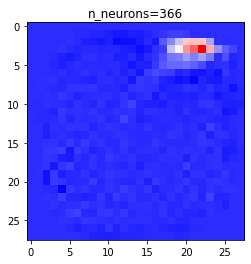

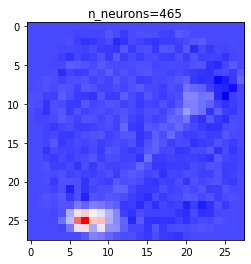

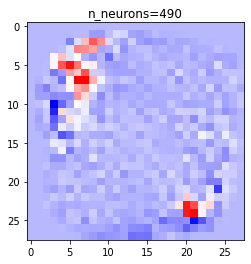

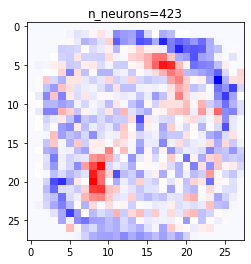

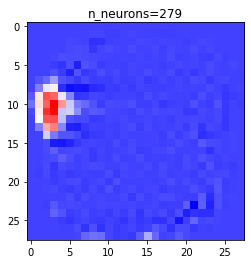

In [ ]:
receptive_fields_act_arr(act_arr,x_test)

In [ ]:
from sklearn.decomposition import PCA
def PCA_receptive_fields_act_arr(act_arr,x_test):
  pc=PCA(n_components=15)
  V=pc.fit_transform(act_arr)
  B0=compute_rfield(x_test,V)
  for j in range(0,15):
    plt.imshow(B0[:,:,j],cmap='bwr')
    plt.title('PC: '+str(j))
    plt.show()

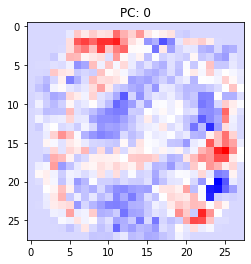

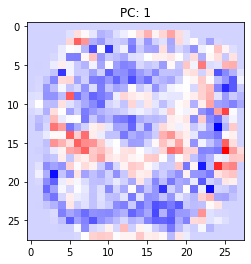

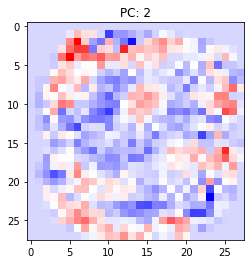

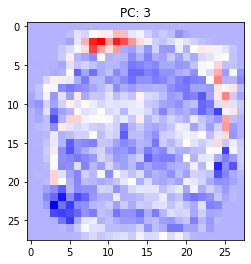

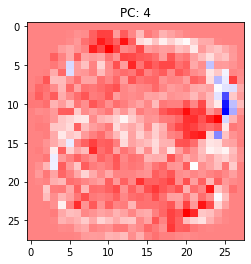

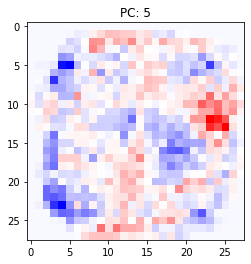

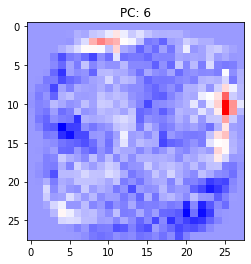

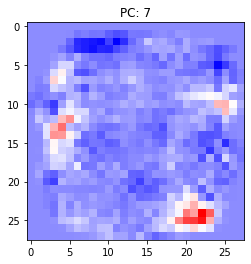

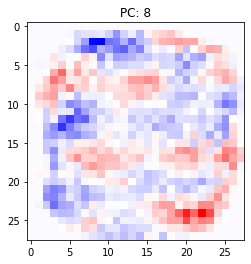

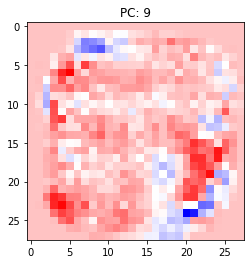

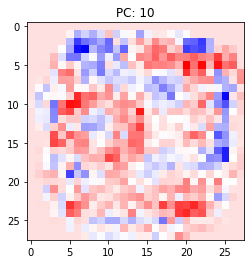

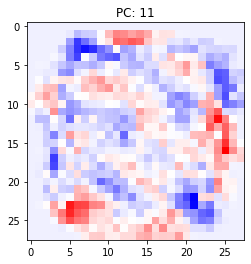

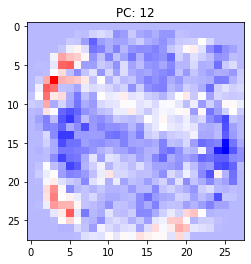

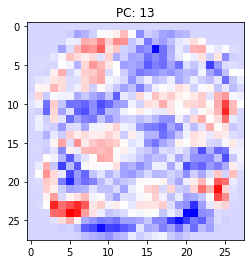

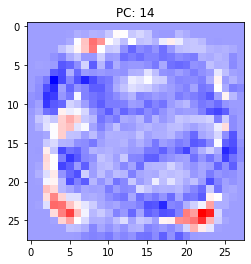

In [ ]:
PCA_receptive_fields_act_arr(act_arr,x_test)

In [ ]:
from sklearn.decomposition import NMF
def NMF_receptive_fields_act_arr(act_arr,x_test):
  pc=NMF(n_components=15)
  V=pc.fit_transform(act_arr)
  B0=compute_rfield(x_test,V)
  for j in range(0,15):
    plt.imshow(B0[:,:,j],cmap='bwr')
    plt.title('NMF component: '+str(j))
    plt.show()

In [ ]:
print(act_arr[act_arr<0].shape)

(102462818,)


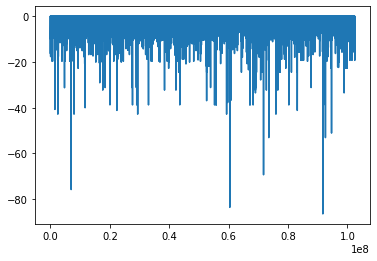

In [ ]:
plt.plot(act_arr[act_arr<0])

In [ ]:
NMF_receptive_fields_act_arr(act_arr,x_test)

ValueError: ignored